In [3]:
import csv
import os

import numpy as np
import pandas as pd
#from owid_downloader import GenerateTrainingData
#from utils import date_today, gravity_law_commute_dist

os.environ['NUMEXPR_MAX_THREADS'] = '16'
os.environ['NUMEXPR_NUM_THREADS'] = '8'

import pickle
import matplotlib.pyplot as plt
import dgl
import torch
from torch import nn
import torch.nn.functional as F
from model import STAN
from ensemble_layer import Feedforward

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from stan_sirvc_layer import run_layer, get_features
import matplotlib.dates as mdates

Using backend: pytorch


In [4]:
#GenerateTrainingData().download_jhu_data('2020-08-01', '2020-12-01')
start_date = '2021-01-01'
end_date = '2021-05-31'

In [5]:
# data processing
raw_data = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv', usecols=["location", "date", "total_cases", "new_cases_smoothed", "total_deaths",
                    "new_deaths", "total_vaccinations", "people_fully_vaccinated", "new_vaccinations", "population"])
raw_data['date'] = pd.to_datetime(raw_data['date'])
mask = (raw_data['date'] >= start_date) & (raw_data['date'] <= end_date) # & (raw_data['location'].isin(countries))
raw_data = raw_data.loc[mask]
#print(raw_data[raw_data['location'] == 'United States']['total_cases'].values[0])
countries = []
loc_list = list(raw_data['location'].unique())
# only include countries that have more than 1000 total cases on start date and at least 1 death
for loc in loc_list:
    if raw_data[raw_data['location'] == loc]["total_cases"].values[0] > 1000 and \
        raw_data[raw_data['location'] == loc]["total_deaths"].values[0] > 0:
        countries.append(loc)
# hard-coded; these are problematic locations (non-countries) that need to be removed
countries.remove("European Union")
countries.remove("Europe")
countries.remove("Africa")
countries.remove("Asia")
countries.remove("North America")
countries.remove("Oceania")
countries.remove("South America")
countries.remove("World")
countries.remove("Tajikistan")
continents = ["Europe", "Africa", "Asia", "North America", "South America", "Oceania"]
world = ["World"]

country_mask = raw_data['location'].isin(countries)
continent_mask = raw_data['location'].isin(continents)
world_mask = raw_data['location'].isin(world)

country_raw_data = raw_data.loc[country_mask]
continent_raw_data = raw_data.loc[continent_mask]
world_raw_data = raw_data.loc[world_mask]

print(len(country_raw_data['location'].unique()))   # 163
print(len(continent_raw_data['location'].unique())) # 6
print(len(world_raw_data['location'].unique()))     # 1

163
6
1


In [6]:
# layer 1, 2, 3
test_window = 29
history_window=14 # days of information
pred_window=14 # predicts future # of days
test_start_date = pd.to_datetime(end_date) + pd.DateOffset(days=-test_window)

g, all_features, active_cases, static_feat, norms = get_features(country_raw_data, start_date, end_date, countries)


<bound method DGLHeteroGraph.number_of_nodes of Graph(num_nodes=163, num_edges=3939,
      ndata_schemes={}
      edata_schemes={})>
done
(18, 3939)
(163, 18, 42)
(1, 3939)
(163, 1, 42)
(1, 3939)
(163, 1, 42)


In [7]:
# all_pred = []
# all_pred_prev = []

# for country in countries:
#     print(country)
#     pred_dI, pred_dI_prev = run_layer(g, all_features, active_cases, static_feat, norms, start_date, end_date, countries, country, True)

#     all_pred.append(pred_dI) # features for continent level
#     all_pred_prev.append(pred_dI_prev)

#     # dates = [test_start_date + pd.DateOffset(days=i+history_window) for i in range(pred_window)]
#     # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
#     # plt.plot(dates, I_true, c='r', label='Ground truth')
#     # plt.plot(dates, pred_I,c='b', label='Proposed')
#     # # stan_res = pickle.load(open(f"stan_results/{loc_name}_stan_results_new", "rb"))
#     # # stan_sirv_res = pickle.load(open(f"stan_results/{loc_name}_stan_results_sirv", "rb"))
#     # # plt.plot(dates, stan_res[-1, :], c='g', label="STAN (SIRV)")
#     # # plt.plot(dates, sir_I[-1, :], c='purple', label="SIRVIC")
#     # plt.gcf().autofmt_xdate()
#     # plt.legend()
#     # plt.ylabel("Number of Active Cases")
#     # plt.title(country)
#     # plt.show()

In [8]:
# pickle.dump(all_pred, open('results/trained_countries_pred_dI', 'wb'), 2)
# pickle.dump(all_pred_prev, open('results/trained_countries_pred_dI_prev', 'wb'), 2)

In [9]:
def get_true(active_data, history_window=14, pred_window=14, slide_step=3):
    timestep = active_data.shape[1]
    I_true = []
    for i in range(0, timestep, slide_step):
        if i+history_window+pred_window-1 >= timestep or i+history_window >= timestep:
            break
        I_true.append(active_data[:, i+history_window:i+history_window+pred_window])
    return I_true

In [10]:
valid_window = 29
test_window = 29

history_window=14 # days of information
pred_window=14 # predicts future # of days
slide_step=3 # increment

_, continent_features, continent_active_cases, continent_static_feat, continent_norms = get_features(continent_raw_data, start_date, end_date, continents, edges=False)
_, world_features, world_active_cases, world_static_feat, world_norms = get_features(world_raw_data, start_date, end_date, world, edges=False)

country_pred = np.array(pickle.load(open('results/trained_countries_pred_dI', 'rb'))).squeeze(2)
country_pred_prev = np.array(pickle.load(open('results/trained_countries_pred_dI_prev', 'rb'))).squeeze(2)

country_pred = (country_pred - world_norms[0]) / world_norms[1]             # normalized by world
country_pred_prev = (country_pred_prev - world_norms[1]) / world_norms[1]   # normalized by world

print(country_pred.shape)
print(country_pred_prev.shape)

done
done
(163, 1, 14)
(163, 19, 14)


In [11]:
I_true = continent_active_cases[0][-test_window:]
I_true = np.array(I_true[history_window:history_window+pred_window])

I_true_train = world_active_cases[:, :-valid_window-test_window]
I_true_train = np.array(get_true(I_true_train), dtype=np.float32).transpose((1, 0, 2))
I_val_train = world_active_cases[:, -valid_window-test_window:-test_window]
I_val_train = np.array(get_true(I_val_train), dtype=np.float32).transpose((1, 0, 2))

I_true_prev = np.concatenate((I_true_train, I_val_train), axis=1)

country_pred_prev = (country_pred_prev - world_norms[0]) / world_norms[1]
country_pred = (country_pred - world_norms[0]) / world_norms[1]

print(I_true)
print(I_true_prev[0][-1])

[1291023. 1246324. 1211357.  803502.  758048.  720689.  707048.  679199.
  621728.  584944.  558622.  531349.  510050.  490237.]
[10079675. 10284108. 10534001. 10739310. 10798984. 10954299. 11110892.
 11142271. 11208749. 11274142. 11363054. 11443912. 11468080. 11476873.]


In [12]:
# world-level MLP from 163 countries (no continent layer)
in_dim = pred_window*len(countries)
hidden_dim = 64
out_dim = pred_window

country_pred = country_pred.transpose(1, 0, 2)
country_pred = country_pred.reshape(country_pred.shape[0], in_dim)

country_pred_prev = country_pred_prev.transpose(1, 0, 2)
country_pred_prev = country_pred_prev.reshape(country_pred_prev.shape[0], in_dim)

print(country_pred.shape)
print(country_pred_prev.shape)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
country_pred = torch.tensor(country_pred, dtype=torch.float32).to(device)
country_pred_prev = torch.tensor(country_pred_prev, dtype=torch.float32).to(device)

y_true = torch.tensor(world_features[2][5], dtype=torch.float32).to(device)
y_true_train = torch.tensor(world_features[0][5], dtype=torch.float32).to(device)
y_true_val = torch.tensor(world_features[1][5], dtype=torch.float32).to(device)

y_true_prev = torch.cat((y_true_train, y_true_val), dim=1)
print(y_true.shape)
print(y_true_prev.shape)

(1, 2282)
(19, 2282)
torch.Size([1, 1, 14])
torch.Size([1, 19, 14])


In [19]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_log_error
model = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(1000,), max_iter=2000)
X_train_input = [x for x in country_pred_prev.detach().cpu().numpy()]
y_train_label = [y for y in y_true_prev.detach().cpu().numpy().squeeze()]
# Output trained model
model.fit(X_train_input, y_train_label)


MLPRegressor(hidden_layer_sizes=(1000,), max_iter=2000, solver='lbfgs')

In [21]:
y_train_pred = model.predict(X_train_input)
print(y_train_pred[0])
print(y_train_label[0])
# fig, ax = plt.subplots()
# ax.plot(model.loss_curve_)

y_pred = model.predict(country_pred.detach().cpu().numpy())
print(y_pred)
print(y_true)

print(I_true)

[-0.06435985  0.07700618 -0.03426169  0.09811494  0.13696397  0.04573934
  0.15672479  0.22732491  0.12045878  0.23242467  0.35401548  0.2643703
  0.26292542  0.40542791]
[-1.164038   -0.7698367  -0.94735515 -0.35973397 -0.9670819  -1.119914
 -1.2600548  -0.7664192  -1.307863   -0.20511517 -1.1961079  -0.8073108
 -1.0588361  -1.1345775 ]
[[-0.06436643  0.07700956 -0.03426563  0.09811813  0.13697404  0.04574071
   0.15673701  0.22733755  0.12046606  0.23243877  0.3540373   0.26438515
   0.26294401  0.40545435]]
tensor([[[-0.9038, -1.2244, -1.1101, -4.2325, -1.3888, -1.3927, -1.0770,
          -1.0881, -1.3849, -1.2731, -1.1138, -1.4682, -0.9412, -1.0183]]],
       device='cuda:0')
[1291023. 1246324. 1211357.  803502.  758048.  720689.  707048.  679199.
  621728.  584944.  558622.  531349.  510050.  490237.]


[[-0.06436643  0.07700956 -0.03426563  0.09811813  0.13697404  0.04574071
   0.15673701  0.22733755  0.12046606  0.23243877  0.3540373   0.26438515
   0.26294401  0.40545435]]
tensor([[[-0.9038, -1.2244, -1.1101, -4.2325, -1.3888, -1.3927, -1.0770,
          -1.0881, -1.3849, -1.2731, -1.1138, -1.4682, -0.9412, -1.0183]]],
       device='cuda:0')


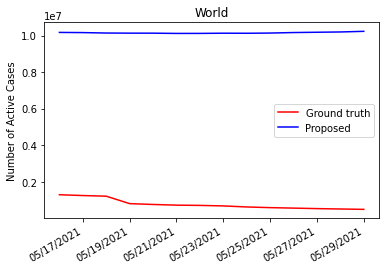

In [22]:
y_pred = model.predict(country_pred.detach().cpu().numpy())
print(y_pred)
print(y_true)

pred_I = []

for i in range(len(y_pred)):
    # below is regular prediction
    cur_pred = (y_pred[i, :] * world_norms[1].reshape(1, 1)) + world_norms[0].reshape(1, 1)
    cur_pred = np.cumsum(cur_pred)
    cur_pred = cur_pred + world_features[2][1][0, i]
    pred_I.append(cur_pred)

pred_I = np.array(pred_I)

import matplotlib.dates as mdates
dates = [test_start_date + pd.DateOffset(days=i+history_window) for i in range(pred_window)]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.plot(dates, I_true, c='r', label='Ground truth')
plt.plot(dates, pred_I[-1, :], c='b', label='Proposed')
# stan_res = pickle.load(open(f"stan_results/{loc_name}_stan_results_new", "rb"))
# stan_sirv_res = pickle.load(open(f"stan_results/{loc_name}_stan_results_sirv", "rb"))
# plt.plot(dates, stan_res[-1, :], c='g', label="STAN (SIRV)")
# plt.plot(dates, sir_I[-1, :], c='purple', label="SIRVIC")
plt.gcf().autofmt_xdate()
plt.legend()
plt.ylabel("Number of Active Cases")
plt.title("World")
plt.show()

In [ ]:
# model = Feedforward(in_dim, hidden_dim, out_dim, device).to(device)
# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# print(model)

In [ ]:
# y_pred = model(country_pred)
# before_train = criterion(y_pred, y_true.squeeze(0))
# print('Test loss before training' , before_train.item())

# epochs = 20
# for epoch in range(epochs):
#     model.train()
#     optimizer.zero_grad()
#     # Forward pass
#     y_pred_prev = model(country_pred_prev)
#     # Compute Loss
#     loss = criterion(y_pred_prev, y_true_prev.squeeze(0))
   
#     print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
#     # Backward pass
#     loss.backward()
#     optimizer.step()

#     model.eval()

# y_pred = model(country_pred)
# after_train = criterion(y_pred, y_true.squeeze(0)) 
# print('Test loss after Training' , after_train.item())

In [ ]:
# print(y_true_prev.squeeze(0).shape)
# print(y_true.squeeze(0))

# print(y_pred_prev.shape)
# print(y_pred)

# for p in model.parameters():
#     if p.grad is not None:
#         print(p.grad.data)